In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

In [2]:
# Load the cepheid and SNe data.
ceph = pd.read_csv('ceph.csv')
sne = pd.read_csv('sne.csv')

# Cut the rejected cepheids.
ceph_cut = ceph['flag'].str.contains('rej', na=False)
ceph = ceph[~ceph_cut]

# Preprocess the host galaxy names in the cepheid catalog.
def proc_ceph_host(x):
    if 'NIC' in x:
        return 'N4258'
    else:
        return 'N' + x[1:5]
    
ceph['host'] = ceph['host'].apply(proc_ceph_host)

# Preprocess the host galaxy names in the SNe catalog.
def proc_sne_host(x):
    return 'N' + x[4:8]
    
sne['host'] = sne['host'].apply(proc_sne_host)

In [3]:
with pm.Model() as model:
    # Set priors for the SNe host distance moduli.
    mu_hosts = {}
    for host in sne['host']:
        mu_hosts[host] = pm.Uniform('mu_%s' % host, lower=-100, upper=100)
    
    # NGC 4258 geometric distance prior.
    d_4258 = pm.Normal('d_4258', mu=7.6, sigma=np.sqrt(0.17**2 + 0.15**2))
    mu_hosts['N4258'] = 5 * np.log10(d_4258) + 25
    pm.Deterministic('mu_N4258', mu_hosts['N4258'])

    # Priors for the remaining model parameters.
    zp = pm.Uniform('zp', lower=-100, upper=100)
    b = pm.Uniform('b', lower=-100, upper=100)
    m_4258 = pm.Uniform('m_4258', lower=-100, upper=100)
    Z = pm.Uniform('Z', lower=-100, upper=100)
    av = pm.Normal('av', mu=0.698, sigma=0.00225)

    # Compute the predicted cepheid apparent magnitudes.
    mu_arr = pm.math.stack([mu_hosts[host] for host in ceph['host']])
    m_pred = (mu_arr - mu_hosts['N4258']) + zp + b * np.log10(ceph['period']) \
        + Z * (np.array(ceph['metallicity']) - 8.66)

    # Cepheid likelihood term.
    pm.Normal('m_cepheids', mu=m_pred, sigma=ceph['mag_err'], observed=ceph['mag'])

    # Compute the predicted SNe apparent magnitudes.
    mu_arr = pm.math.stack([mu_hosts[host] for host in sne['host']])
    m_pred = (mu_arr - mu_hosts['N4258']) + m_4258

    # SNe likelihood term.
    m_sne = pm.Normal('m_sne', mu=m_pred, sigma=sne['m_err'], observed=np.array(sne['m+5av']) - 5 * av)

    # Compute H0
    H0 = np.power(10, (m_4258 - mu_hosts['N4258'] + 5 * av + 25)/5)
    pm.Deterministic('H0', H0)
    
    # Run the sampler.
    trace = pm.sample(cores=16, tune=10000, draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [av, Z, m_4258, b, zp, d_4258, mu_N1309, mu_N3021, mu_N3370, mu_N3982, mu_N4639, mu_N4536]


Sampling 16 chains for 10_000 tune and 10_000 draw iterations (160_000 + 160_000 draws total) took 257 seconds.
The acceptance probability does not match the target. It is 0.6605988930564639, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6018 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.558633155920349, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5670 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5914982613964905, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7030 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.592041391845165, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective 

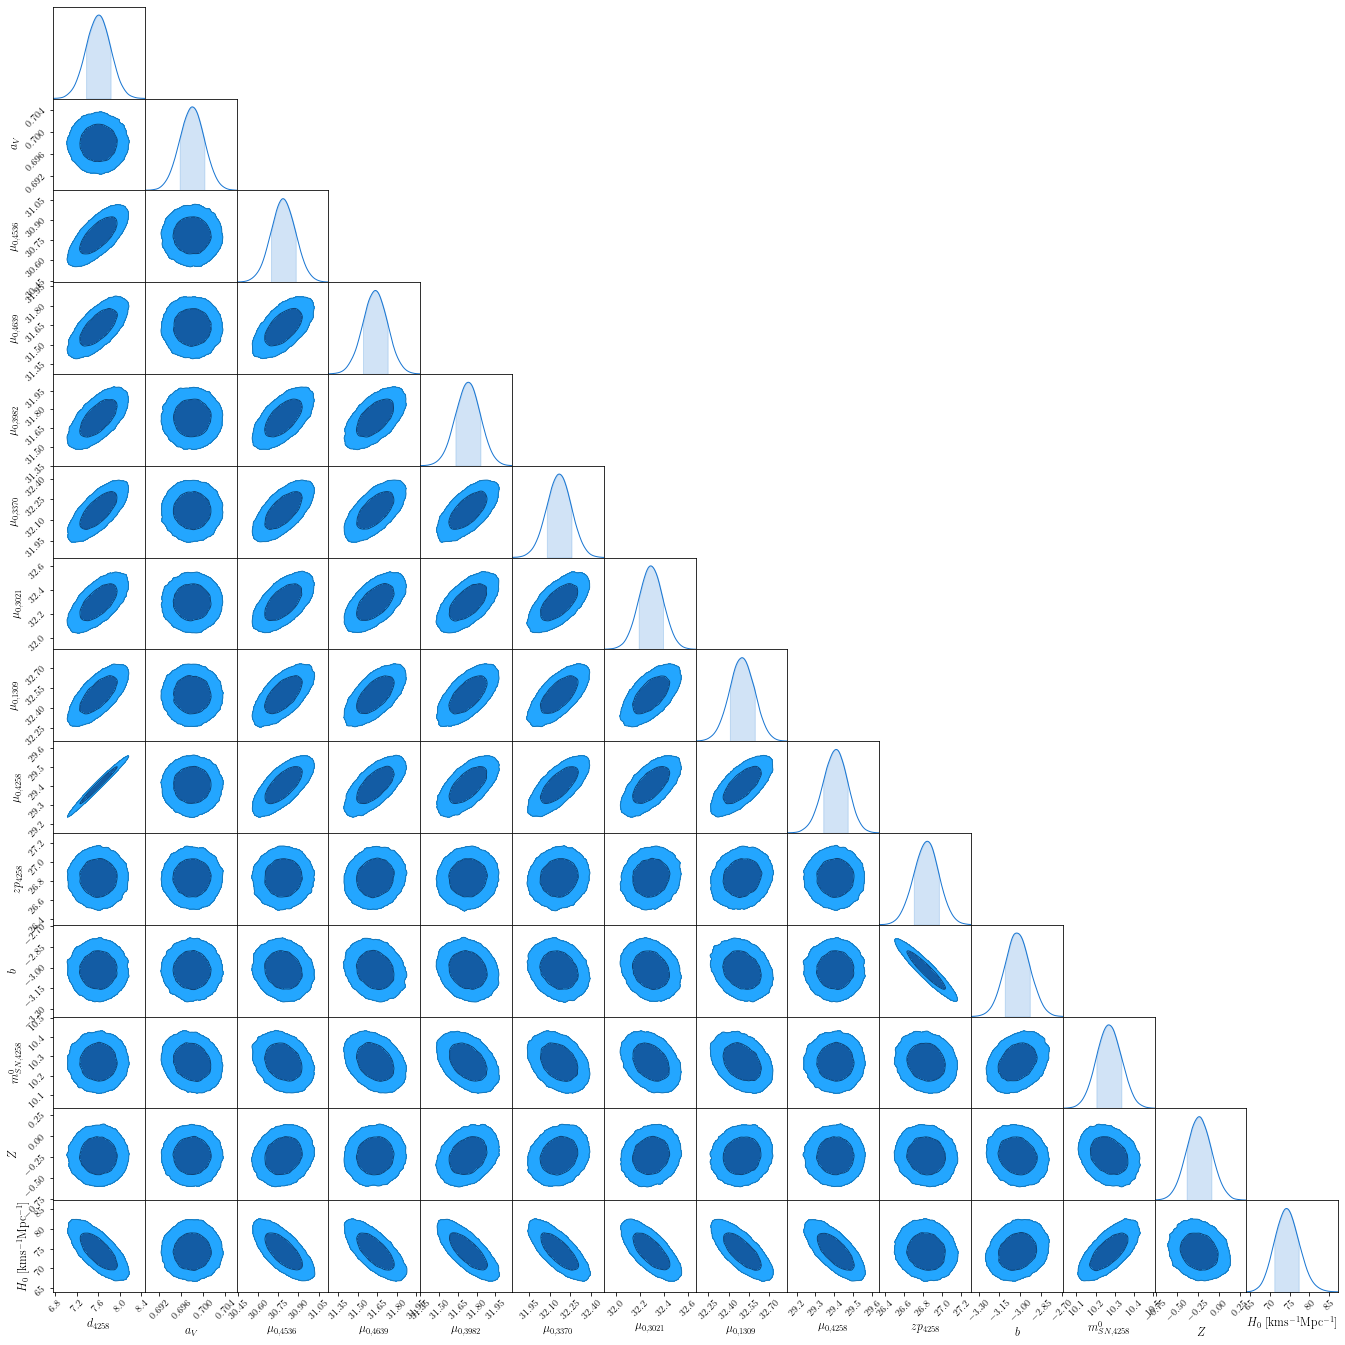

In [4]:
var_names = [
    'd_4258',
    'av',
    'mu_N4536',
    'mu_N4639',
    'mu_N3982',
    'mu_N3370',
    'mu_N3021',
    'mu_N1309',
    'mu_N4258',
    'zp',
    'b',
    'm_4258',
    'Z',
    'H0'
]

params = [
    '$d_{4258}$',
    '$a_V$',
    '$\mu_{0,4536}$',
    '$\mu_{0,4639}$',
    '$\mu_{0,3982}$',
    '$\mu_{0,3370}$',
    '$\mu_{0,3021}$',
    '$\mu_{0,1309}$',
    '$\mu_{0,4258}$',
    '$zp_{4258}$',
    '$b$',
    '$m_{SN,4258}^0$',
    '$Z$',
    r'$H_0\ [{\rm km s^{-1} Mpc^{-1}}]$'
]

chain = np.stack([trace[var] for var in var_names], axis=-1)

c = ChainConsumer()
c.add_chain(chain, parameters=params, name="This work")
c.plotter.plot(filename='corner.png')
plt.show()

In [5]:
# Riess et.al 2009 result
mean, stdev = 74.2, 3.4
chain2 = np.random.normal(mean, stdev, size=1000000)
c.add_chain(chain2, parameters=[r'$H_0\ [{\rm km s^{-1} Mpc^{-1}}]$'], name="Riess et al. (2009)")

74.39135101080512


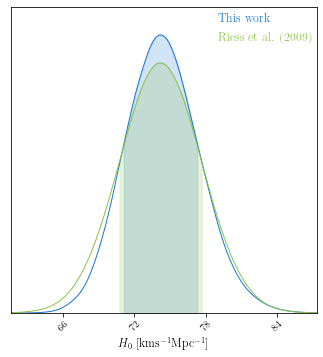

In [6]:
c.plotter.plot(filename='H0.png', parameters=[r'$H_0\ [{\rm km s^{-1} Mpc^{-1}}]$'], figsize='column')
plt.savefig("H0-dist.png", dpi=300)
print(trace["H0"].mean())